In [526]:
import jax.numpy as np
import numpy as npy
import cvxpy as cp
import jax
import matplotlib.pyplot as plt
# import gurobipy
import ecos
import scipy.linalg as la

from dataclasses import dataclass

In [527]:
# hyperparameter definition
N = 200
t0 = 0
m0 = 2.0
alpha = 0.0034
r0 = np.array([4.5, 16.5])
rf = np.array([0.0, 0.0])
v0 = np.array([-10.0, -1.5])
vf = np.array([0.0, 0.0])
omega0 = 0
omegaf = 0
theta0 = 0
thetaf = 0
g = -1.0
gamma_min = 1.5
gamma_max = 6.5
tau_max = 1
J = 0.25
terminal_weight = 100.0
trust_weight = 1E-2

We will define our state as follows:

\begin{align*}
    x = \begin{bmatrix} m(t)\\r(t)\\v(t)\\\theta(t)\\\omega(t) \end{bmatrix}
\end{align*}

It is important to note that both $r$ and $v$ are denoted in y-z coordinates.

We define our control vector as follows:

\begin{align*}
    u = \begin{bmatrix} \Gamma(t)\\\tau(t) \end{bmatrix}
\end{align*}

In [528]:
def f(x, u, params):
    '''
    State-space dynamics for the planar descent vehicle
    Inputs:
        x = [m, r, v, omega, theta] has 7 elements
        u = [Gamma, tau] has 2 elements
    Outputs:
        xdot = [m_dot, r_dot, v_dot, omega_dot, theta_dot] has 7 elements
    '''

    # extract state and control variables
    m = x[0]
    r = x[1:3]
    v = x[3:5]
    omega = x[5]
    theta = x[6]
    Gamma = u[0]
    tau = u[1]

    # extract the parameters
    alpha = params.alpha
    g = params.g * np.array([0, 1])
    J = params.J

    # other intermdeiate variables
    d = np.array([-np.sin(theta), np.cos(theta)])

    m_dot = -alpha * Gamma
    r_dot = v
    v_dot = Gamma / m * d + g
    theta_dot = omega
    omega_dot = tau / J

    xdot = np.array([m_dot, r_dot[0], r_dot[1], v_dot[0], v_dot[1], omega_dot, theta_dot])
    return xdot

In [529]:
def A_jac(x, u, params):
    m = x[0]
    r = x[1:3]
    v = x[3:5]
    omega = x[5]
    theta = x[6]
    Gamma = u[0]
    tau = u[1]


    # extract the parameters
    alpha = params.alpha
    g = params.g * np.array([0, 1])
    J = params.J

    A = np.array([
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [Gamma/m**2 * np.sin(theta), 0., 0., 0., 0., Gamma/m * np.cos(theta), 0.],
        [-Gamma/m**2 * np.cos(theta), 0., 0., 0., 0., -Gamma/m * np.sin(theta), 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]
    ])

    return A

def B_jac(x, u, params):
    m = x[0]
    r = x[1:3]
    v = x[3:5]
    omega = x[5]
    theta = x[6]
    Gamma = u[0]
    tau = u[1]


    # extract the parameters
    alpha = params.alpha
    g = params.g * np.array([0., 1.])
    J = params.J

    B = np.array([
        [-alpha, 0.],
        [0., 0.],
        [0., 0.],
        [-np.sin(theta)/m, 0.],
        [np.cos(theta)/m, 0.],
        [0., 0.],
        [0., 1/J]
    ])

    return B

def C_jac(x, u, A, B, params):
    return f(x, u, params) - A @ x - B @ u


In [530]:
def linearize_dynamics(x, u, params):
    A = jax.jacfwd(f, argnums=0)(x, u, params)
    B = jax.jacfwd(f, argnums=1)(x, u, params)
    z = f(x, u, params) - A @ x - B @ u
    return A, B, z

In [531]:
def discrete_step(x_bar, u_bar, x, u, params):
    dt = params.dt
    A, B, z = linearize_dynamics(x_bar, u_bar, params)
    return (A * dt + np.eye(A.shape[0])) @ x + (B * dt) @ u + z*dt

In [532]:
def scaled_dynamics(x, u, t_f, params):
    return t_f * f(x, u, params)

In [533]:
def discretized_dynamics(dt, state, control, params):
        A,B,_ = linearize_dynamics(state, control, params)
        state = npy.array(state)
        control = npy.array(control)
        A = npy.array(A)
        B = npy.array(B)

        Xi = npy.zeros((A.shape[0]*3 + B.shape[1], A.shape[0]*3 + B.shape[1]))
        Xi[:A.shape[0], :A.shape[0]] = A
        Xi[A.shape[0]:2*A.shape[0], A.shape[0]:2*A.shape[0]] = -A.T
        Xi[2*A.shape[0]:3*A.shape[0], 2*A.shape[0]:3*A.shape[0]] = A
        Xi[2*A.shape[0]:3*A.shape[0], 3*A.shape[0]:] = B
        Y = la.expm(Xi*dt)
        
        A_d = Y[:A.shape[0], :A.shape[0]]
        B_d = Y[2*A.shape[0]:3*A.shape[0], 3*A.shape[0]:]
        return np.array(A_d), np.array(B_d)

Next, we need to assign the parameters that go into our dynamics as an object

In [534]:
@dataclass
class Params:
    N: int
    dt: float
    alpha: float
    g: float
    J: float
    tau_max: float
    gamma_min: float
    gamma_max: float

In [535]:
problem_params = Params(N=N, dt=0.1, alpha=alpha, g=g, J=J, tau_max=tau_max, gamma_min=gamma_min, gamma_max=gamma_max)

Next, we need to linearize our dynamics since they are nonlinear

In [536]:
x0 = np.array([m0, *r0, *v0, omega0, theta0])
t_f = 9
dt = t_f / N
problem_params.dt = dt
# A, B, C = linearize_dynamics(x0, u0, problem_params)

iterations = 10

# Formulating as an SCP problem

In [537]:
x0 = np.array([m0, *r0, *v0, omega0, theta0])
u0 = np.array([6.5, 0.0])
xf = np.array([1.8, *rf, *vf, omegaf, thetaf])
uf = np.array([1.5, 0.0])

x_guess = np.linspace(x0, xf, N+1)
u_guess = np.linspace(u0, uf, N)

for i in range(iterations):
    print(f"Iteration {i+1}")
    x = cp.Variable((N+1, 7))
    u = cp.Variable((N, 2))
    epsilon = cp.Variable(7)
    # uncomment for MIP
    z = cp.Variable(N, boolean=True)  # Binary variable indicating the switch
    s = cp.Variable(N-1, boolean=True)  # Binary switch indicator

    cost = 0
    constraints = []

    # Uncomment for MIP
    # Constraint: u[:, 0] should be close to either 1.5 or 6.5
    constraints += [
        u[:, 0] >= gamma_min * (1 - z) + gamma_max * z - 0.01,  # Allow small tolerance
        u[:, 0] <= gamma_min * (1 - z) + gamma_max * z + 0.01   # Allow small tolerance
    ]

    # Penalize only when u[:, 0] is not 1.5 or 6.5
    # uncomment for MIP problem
    cost = cp.sum(cp.abs(u[:, 0] - (gamma_min * (1 - z) + gamma_max * z)))

    for t in range(N-1):
        constraints.append(s[t] >= z[t+1] - z[t])  # Detect upward switches
        constraints.append(s[t] >= z[t] - z[t+1])  # Detect downward switches

    # Limit number of switches
    S_max = 3  # Change this to adjust the allowed number of switches
    constraints.append(cp.sum(s) == S_max)

    # cost += 1E0 * cp.sum_squares(u[:, 0])    
    cost += 1E-1*cp.sum(cp.abs(u[:, 0]))
    cost += 1E-1*(x0[0] - x[-1, 0])
    # cost += tf
    # cost += cp.quad_form(x[-1, 3:5] - xf[3:5], terminal_weight * np.eye(2))
    # cost += cp.quad_form(x[-1, 1:3] - xf[1:3], terminal_weight * np.eye(2))
    # cost += sum(cp.quad_form(x[i, :] - x_guess[i, :], trust_weight * np.eye(7)) for i in range(N+1))    
    # cost += sum(cp.quad_form(u[i, :] - u_guess[i, :], trust_weight * np.eye(2)) for i in range(N))
    cost += sum(trust_weight * (cp.sum_squares(x[j] - x_guess[j]))for j in range(N+1))
    cost += sum(trust_weight * (cp.sum_squares(u[j] - u_guess[j])) for j in range(N))
    cost += 1E3 * cp.sum(cp.abs(epsilon))
    # cost += 10 * epsilon[1]**2
    
    # constraints += [x[0] == x0]
    constraints += [u[0, :] == u0]
    constraints += [x[0, 0:6] == x0[0:6]]
    # constraints += [x[0, -1] == x0[-1]]
    constraints += [u[:, 0] >= gamma_min]
    constraints += [u[:, 0] <= gamma_max]
    constraints += [u[:, 1] <= tau_max]
    constraints += [u[:, 1] >= -tau_max]
    constraints += [x[-1, 1:] == xf[1:]]
    
    constraints += [x[:i, 2] >= x[i, 2] for i in range(1, N+1)]
    constraints += [x[:, 2] <= x0[2]]
    constraints += [x[:, 2] >= 0]
    constraints += [x[:, 1] <= 100]
    constraints += [x[:, 1] >= -100]
    constraints += [x[:, 3] <= 2000]
    constraints += [x[:, 3] >= -2000]
    constraints += [x[:, 4] <= 2000]
    constraints += [x[:, 4] >= -2000]
    constraints += [x[:, 0] <= m0]
    constraints += [x[:, 0] >= 0]
    
    
    # constraints += [epsilon >= 0.0]
    # constraints += [tf >= tf_min]
    # constraints += [tf <= tf_max]

    # dt = tf / N
    for k in range(N):
        # A = A_jac(x_guess[i, :], u_guess[i, :], problem_params)
        # B = B_jac(x_guess[i, :], u_guess[i, :], problem_params)
        # C = C_jac(x_guess[i, :], u_guess[i, :], A, B, problem_params)
        # constraints += [x[i+1] == (A @ x[i] + (B) @ u[i] + C) * dt + x[i]]
        constraints += [x[k+1] == discrete_step(x_guess[k, :], u_guess[k, :], x[k, :], u[k, :], problem_params) + epsilon]
        # A ,B = discretized_dynamics(dt, x_guess[k, :], u_guess[k, :], problem_params)
        # constraints += [x[k+1] - x_guess[k] == A @ (x[k] - x_guess[k]) + B @ (u[k] - u_guess[k]) + epsilon]

    objective = cp.Minimize(cost)
    problem = cp.Problem(objective, constraints)
    # could use any cvx solver here
    problem.solve(solver=cp.GUROBI, verbose=True, warm_start=True, TimeLimit=60, MIPGap=0.0025)
    problem = None

    print(np.sum(abs(epsilon.value)))

    x_guess = np.array(x.value)
    u_guess = np.array(u.value)

    if np.sum(abs(epsilon.value)) < 1E-6 and i > iterations - 5:# or np.sum(abs(epsilon.value)) == 0.0:
        print("Converged!")
        break

    



Iteration 1
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Mar 11 10:13:08 AM: Your problem has 2213 variables, 25123 constraints, and 0 parameters.
(CVXPY) Mar 11 10:13:08 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 11 10:13:08 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 11 10:13:08 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 11 10:13:08 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 11 10:13:08 AM: Compiling problem (target 

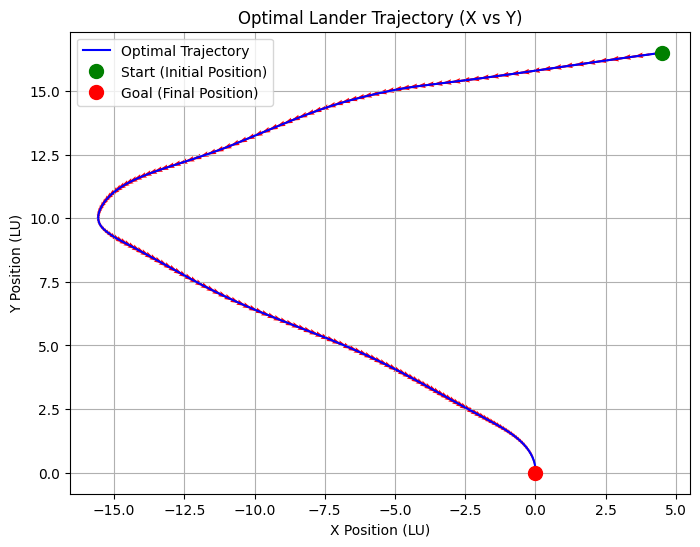

In [538]:
r_x = x.value[:, 1]  # x position
r_y = x.value[:, 2]  # y position
v_x = x.value[:, 3]
v_y = x.value[:, 4]

# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(r_x, r_y, 'b-', label="Optimal Trajectory")  # Blue line with circles
plt.plot(x0[1], x0[2], 'go', markersize=10, label="Start (Initial Position)")  # Green start point
plt.plot(xf[1], xf[2], 'ro', markersize=10, label="Goal (Final Position)")  # Red target point

# Add velocity vector arrows
scale_factor = 0.1  # Adjust for arrow size
plt.quiver(r_x, r_y, v_x, v_y, angles='xy', scale_units='xy', scale=1/scale_factor, color='r', width=0.003)

# Labels and formatting
plt.xlabel("X Position (LU)")
plt.ylabel("Y Position (LU)")
plt.title("Optimal Lander Trajectory (X vs Y)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

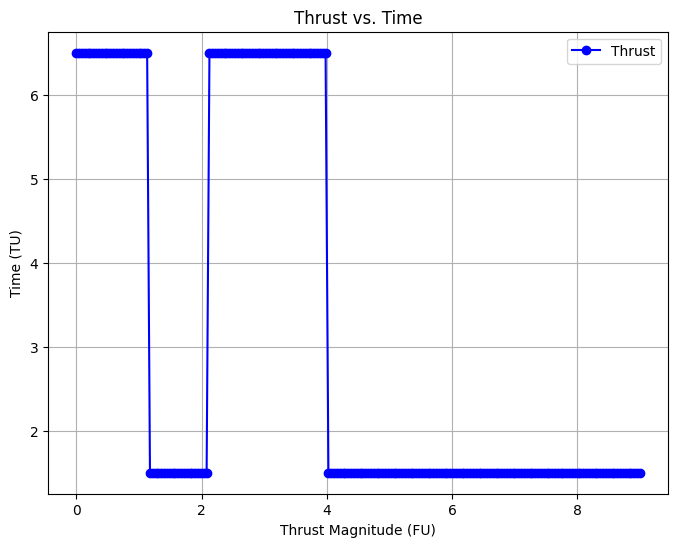

In [539]:
# Plot the trajectory
ts = np.linspace(0, t_f, N)

plt.figure(figsize=(8, 6))
plt.plot(ts, u.value[:, 0], 'bo-', label="Thrust")  # Blue line with circles

# Labels and formatting
plt.xlabel("Thrust Magnitude (FU)")
plt.ylabel("Time (TU)")
plt.title("Thrust vs. Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

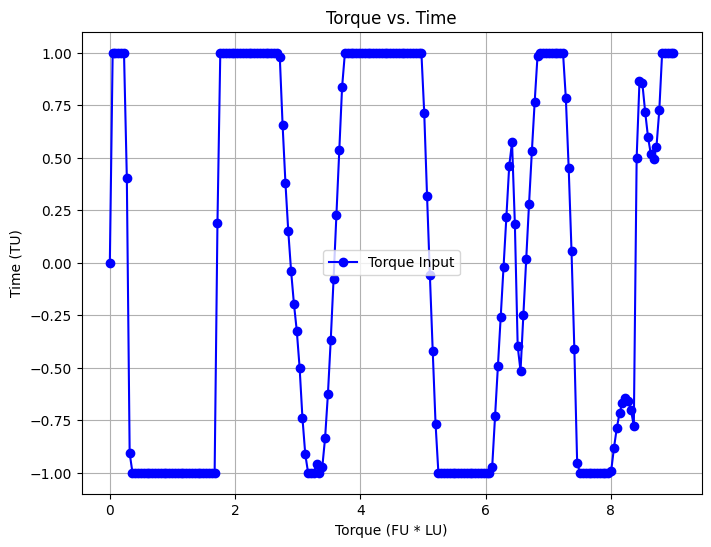

In [542]:
# Plot the trajectory
ts = np.linspace(0, t_f, N)

plt.figure(figsize=(8, 6))
plt.plot(ts, u.value[:, 1], 'bo-', label="Torque Input")  # Blue line with circles

# Labels and formatting
plt.xlabel("Torque (FU * LU)")
plt.ylabel("Time (TU)")
plt.title("Torque vs. Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [541]:
x.value[-1]

array([ 0.38347775, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ])